# Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d
from PIL import Image, ExifTags
# import datetime as dt
import pytz
from datetime import datetime as DT
import pandas as pd
from lxml import etree
from dateutil import parser

### Input variables

In [2]:
# unique to local files:
homedir = r'/Users/emilysturdivant/Desktop/uas_data'
logfile = os.path.join(homedir, 'f8.gpx')
imagefolder = os.path.join(homedir, 'f8')

# Standard:
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}
tfmt_exif = '%Y:%m:%d %H:%M:%S' #2017-05-04T14:14:12-04:00
tfmt_gpx = '%Y-%m-%dT%H:%M:%S-04:00' #2017-05-04T14:14:12-04:00
iso_fmt="%Y%m%dT%H%M%SZ"

# Mission info
survey_id = '2016-010FA'
uas_id = 'u031'
fc_id = 'f04r01'

### Functions

In [3]:
def dt_to_UTCval(dtstr, fmt, local_tz='US/Eastern'):
    time = (pytz.timezone(local_tz).localize(DT.strptime(e.text, tfmt_gpx), is_dst=None)
                                .astimezone(pytz.utc)
                                .timestamp())
    return(time)

def gpx_tag_to_pdseries(tree, namespace, tag):
    elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
    ser = pd.Series([e.text for e in elist], name=tag)
    return(ser)

### Parse GPX and extract components into dataframe

In [4]:
# Parse GPX and extract components into dataframe
tree = etree.parse(logfile)

# latitude and longitude
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
gpxdf = pd.DataFrame([e.values() for e in elist], columns=['lat', 'lon'])

# all other tags
taglist = ['ele', 'ele2', 'course', 'roll', 'pitch', 'mode']
for tag in taglist:
    gpxdf = gpxdf.join(gpx_tag_to_pdseries(tree, namespace, tag))

# time
tag = 'time'
elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
dt = [parser.parse(e.text) for e in elist] # parser will detect time zones
print(dt[:4])
dtz = [dti.astimezone(pytz.utc) for dti in dt]
print(dtz[:4])
# dtz = [time.mktime(dti.utctimetuple()) for dti in dt]
gpxdf = gpxdf.join(pd.DataFrame({'time_utc':dtz, 'time_epoch': [t.timestamp() for t in dtz]}))
# dtz = [pytz.timezone(local_tz).localize(DT.strptime(e.text, tfmt_gpx), is_dst=None).astimezone(pytz.utc) for e in elist]
# t = [dt.timestamp() for dt in img_dt]
# gpxdf = gpxdf.join(pd.DataFrame({'time_utc':dtz, 'time_epoch': [t.timestamp() for t in dt]}))

gpxdf.head()

[datetime.datetime(2017, 6, 13, 10, 38, 22, tzinfo=tzoffset(None, -14400)), datetime.datetime(2017, 6, 13, 10, 38, 22, tzinfo=tzoffset(None, -14400)), datetime.datetime(2017, 6, 13, 10, 38, 22, tzinfo=tzoffset(None, -14400)), datetime.datetime(2017, 6, 13, 10, 38, 23, tzinfo=tzoffset(None, -14400))]
[datetime.datetime(2017, 6, 13, 14, 38, 22, tzinfo=<UTC>), datetime.datetime(2017, 6, 13, 14, 38, 22, tzinfo=<UTC>), datetime.datetime(2017, 6, 13, 14, 38, 22, tzinfo=<UTC>), datetime.datetime(2017, 6, 13, 14, 38, 23, tzinfo=<UTC>)]


,lat,lon,ele,ele2,course,roll,pitch,mode,time_epoch,time_utc
0,36.1819669,-75.7515419,-6.01,0,0,0,0,Loiter,1.497365e+09,2017-06-13 14:38:22+00:00
1,36.1819669,-75.7515419,-6.92,0.07,0,0,0,Loiter,1.497365e+09,2017-06-13 14:38:22+00:00
2,36.1819671,-75.7515419,-6.9,0.09,42.36301,-0.2109267,1.303254,Loiter,1.497365e+09,2017-06-13 14:38:22+00:00
3,36.1819672,-75.7515419,-6.89,0.1,42.36145,-0.1979842,1.311603,Loiter,1.497365e+09,2017-06-13 14:38:23+00:00
4,36.1819673,-75.7515419,-6.89,0.1,42.36665,-0.1992989,1.30895,Loiter,1.497365e+09,2017-06-13 14:38:23+00:00


#### Export CSV

In [5]:
# Export CSV: logfile_gpx.csv stored in same folder as logfile
gpxdf.to_csv(os.path.splitext(logfile)[0]+'_gpx.csv', index=False)

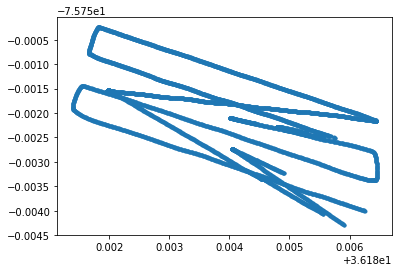

In [6]:
#%% PLOT!
plt.plot(gpxdf.lat,gpxdf.lon,'.')
plt.show()

## Work with images
Replace original images because this will consider current filenames "original" and will replace. 

In [7]:
# List all JPEGS in imagefolder
flist=[os.path.join(imagefolder,f) for f in os.listdir(imagefolder) if f.endswith('.jpg') or f.endswith('.JPG')]
print("Found {} images in {}.".format(len(flist),imagefolder))

# Get filename and DateTimeOriginal of each photo
#FIXME: how to get tzinfo from EXIF? Looks like these were recorded in UTC...
dt = [pytz.utc.localize(DT.strptime(Image.open(f)._getexif()[36867], tfmt_exif)) for f in flist] # make timezone aware (UTC) for later comparison with GPX times
imgdf = pd.DataFrame({'orig_name': [os.path.basename(f) for f in flist],
                      'time_utc': dt,
                      'time_epoch': [t.timestamp() for t in dt],
                      'time_iso': [t.strftime(iso_fmt) for t in dt],
                      'new_name': np.nan})
imgdf.head()

Found 188 images in /Users/emilysturdivant/Desktop/uas_data/f8.


,new_name,orig_name,time_epoch,time_iso,time_utc
0,NaN,2016-010FA_u031_f04r01_20170613T143454Z_B00090...,1.497364e+09,20170613T143454Z,2017-06-13 14:34:54+00:00
1,NaN,2016-010FA_u031_f04r01_20170613T144248Z_B00091...,1.497365e+09,20170613T144248Z,2017-06-13 14:42:48+00:00
2,NaN,2016-010FA_u031_f04r01_20170613T144250Z_B00091...,1.497365e+09,20170613T144250Z,2017-06-13 14:42:50+00:00
3,NaN,2016-010FA_u031_f04r01_20170613T144252Z_B00091...,1.497365e+09,20170613T144252Z,2017-06-13 14:42:52+00:00
4,NaN,2016-010FA_u031_f04r01_20170613T144254Z_B00091...,1.497365e+09,20170613T144254Z,2017-06-13 14:42:54+00:00


In [8]:
# Export CSV
imgdf.to_csv(imagefolder+'_stage1.csv', index=False)

In [9]:
# print first and last image name and times
print("First... file: {}, time: {}".format(imgdf.orig_name.iloc[0],imgdf.time_utc.iloc[0]))
print("Last... file: {}, time: {}".format(imgdf.orig_name.iloc[-1],imgdf.time_utc.iloc[-1]))
# print first and last times in .gpx file
print("{} from {} to {}".format(logfile, gpxdf.time_utc.iloc[0],gpxdf.time_utc.iloc[-1]))

First... file: 2016-010FA_u031_f04r01_20170613T143454Z_B0009085.JPG, time: 2017-06-13 14:34:54+00:00
Last... file: 2016-010FA_u031_f04r01_20170613T144900Z_B0009316.JPG, time: 2017-06-13 14:49:00+00:00
/Users/emilysturdivant/Desktop/uas_data/f8.gpx from 2017-06-13 14:38:22+00:00 to 2017-06-13 14:55:08+00:00


### Rename photos

In [10]:
# Rename photos
#TODO move/copy them first? / don't run if the names have already been changed...
for idx, row in imgdf.iterrows():
    img = row.orig_name
    new_name = "{}_{}_{}_{}_{}".format(survey_id, uas_id, fc_id, row.time_iso, img) # ->
    os.rename(os.path.join(imagefolder, img), os.path.join(imagefolder, new_name))
#     imgdf.new_name.loc[idx] = new_name


# More direct from Sherwood interp:

### Interpolation from Sherwood, modified to DF inputs

In [11]:
# Convert to NP formats and combine .gpx data into array
data = np.zeros((3,(len(gpxdf.lat))))
data[0,:]=gpxdf.lat
data[1,:]=gpxdf.lon
data[2,:]=gpxdf.ele

dn = np.array(gpxdf.time_epoch)
img_dn = np.array(imgdf.time_epoch)
img_name = np.array(imgdf.orig_name)

# set up interpolation
set_interp = interp1d(dn, data, kind='linear')

# array for storing lat, lon, and elevation for each image
img_nogps = []
img_data = np.ones((3, len(img_name)))*np.nan
for i in range(len(img_name)):
    if(img_dn[i]>=dn[0] and img_dn[i]<=dn[-1]):
        # image time is within bounds of .gpx data
        img_data[:,i] = set_interp(img_dn[i])
    else:
        # image time is not within .gpx data
        img_nogps.append(img_name[i])
        print(img_dn[i], dn[0], dn[-1])
        
print('No GPS data for {} images out of {}'.format(len(img_nogps), len(img_name)))

1497364494.0 1497364702.0 1497365708.0
No GPS data for 1 images out of 188


In [12]:
# Convert to NP formats and combine .gpx data into array
data = np.zeros((3,(len(gpxdf.lat))))
data[0,:]=gpxdf.lat
data[1,:]=gpxdf.lon
data[2,:]=gpxdf.ele

dn = np.array(gpxdf.time_utc)
img_dn = np.array(imgdf.time_utc)
img_name = np.array(imgdf.orig_name)

In [15]:
# Datetime objects can be compared, but both need to be either tz-aware or unaware.
timecol = 'time_utc'
start_gpxtime = gpxdf[timecol].min()
end_gpxtime = gpxdf[timecol].max()
print('GPS start: {}\nGPS end: {}'.format(start_gpxtime, end_gpxtime))
# tooearly = imgdf[timecol] <= start_gpxtime
# toolate = imgdf[timecol] >= end_gpxtime

# # use where to find image times within bounds of gps times
# ser = imgdf[timecol]
# ser.where(ser >= start_gpxtime and ser <= start_gpxtime, np.nan)
# try this?
matches = gpxdf[gpxdf.time_epoch.isin(imgdf.time_epoch)] # All rows in df1 that have a match in df2.
matches.head()

GPS start: 2017-06-13 14:38:22+00:00
GPS end: 2017-06-13 14:55:08+00:00


,lat,lon,ele,ele2,course,roll,pitch,mode,time_epoch,time_utc
1041,36.1819936,-75.7515427,-7.1,0.13,32.70589,-0.3473826,1.046628,Loiter,1.497365e+09,2017-06-13 14:42:48+00:00
1042,36.1819935,-75.7515427,-7.1,0.13,32.72327,-0.334433,1.036898,Loiter,1.497365e+09,2017-06-13 14:42:48+00:00
1043,36.1819934,-75.7515428,-7.1,0.13,32.71679,-0.3511682,1.020996,Loiter,1.497365e+09,2017-06-13 14:42:48+00:00
1044,36.1819933,-75.7515428,-7.09,0.14,32.72688,-0.385768,1.032633,Loiter,1.497365e+09,2017-06-13 14:42:48+00:00
1045,36.1819933,-75.7515429,-7.09,0.14,32.73014,-0.3838604,1.036255,Loiter,1.497365e+09,2017-06-13 14:42:48+00:00


In [20]:
# try loop with DF operations
timecol = 'time_epoch'
start_gpxtime = gpxdf[timecol].min()
end_gpxtime = gpxdf[timecol].max()

# loop through the images and interpolate .gpx data
img_nogps = []
img_data = np.ones((3, len(img_name)))*np.nan
for idx, row in imgdf.iterrows():
    img_tznum = row[timecol]
    if img_tznum >= start_gpxtime and img_tznum <= end_gpxtime:
        [lat, lon, ele] = set_interp(img_tznum)
        imgdf['lat'] = lat
        imgdf['lon'] = lon
        imgdf['ele'] = ele
        img_data[:,idx] = set_interp(img_tznum)
    else: # image time is not within .gpx data
        img_nogps.append(row.orig_name)
        print('Image {} not acquired between {} and {}'.format(row.orig_name, start_gpxtime, end_gpxtime))
        
img_datadf = pd.DataFrame(img_data).transpose()
print(img_datadf.head())
print(imgdf.head())

Image 2016-010FA_u031_f04r01_20170613T143454Z_B0009085.JPG not acquired between 1497364702.0 and 1497365708.0
           0          1     2
0        NaN        NaN   NaN
1  36.181993 -75.751543 -7.09
2  36.181993 -75.751543 -7.05
3  36.181992 -75.751543 -7.00
4  36.181992 -75.751543 -1.12
   new_name                                          orig_name    time_epoch  \
0       NaN  2016-010FA_u031_f04r01_20170613T143454Z_B00090...  1.497364e+09   
1       NaN  2016-010FA_u031_f04r01_20170613T144248Z_B00091...  1.497365e+09   
2       NaN  2016-010FA_u031_f04r01_20170613T144250Z_B00091...  1.497365e+09   
3       NaN  2016-010FA_u031_f04r01_20170613T144252Z_B00091...  1.497365e+09   
4       NaN  2016-010FA_u031_f04r01_20170613T144254Z_B00091...  1.497365e+09   

           time_iso                  time_utc        lat        lon    ele  
0  20170613T143454Z 2017-06-13 14:34:54+00:00  36.186037 -75.752665  92.79  
1  20170613T144248Z 2017-06-13 14:42:48+00:00  36.186037 -75.752665  92.79 

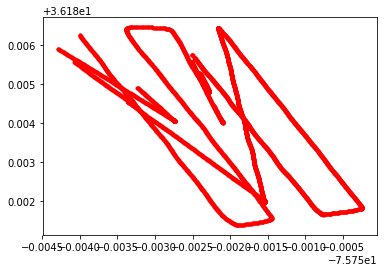

NameError: name 'img_dt' is not defined

In [18]:
# make a bare-bones trackline and overlay image locations, sherwood direct
plt.plot(imgdf.lon, imgdf.lat,'-')
plt.plot(gpxdf.lon, gpxdf.lon,'.r')
plt.show()
# print out file name, time, and data
# TODO - write a .csv file with columns in the in the correct order for Photoscan